In [1]:
import numpy as np
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Activation, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D, Dropout
from keras.models import Model
from keras.utils import to_categorical
from matplotlib import pyplot as plt

Using TensorFlow backend.


# Data Setup

In [2]:
def parseCSV(file):
    data = pd.read_csv(file)
    data = data
    data["Word"]= data["Word"].str.lower()
    data['Index'] = np.arange(len(data))
    return data[['Word', 'Language', "Index"]]

In [3]:
class CNN():
    def __init__(self, train_data_source, test_data_source):
        self.train_df = train_data_source
        self.test_df = test_data_source

        self.x_train = np.array(self.train_df["Word"])
        self.x_test = np.array(self.test_df["Word"])

        CHAR_STRING = 'abcdefghijklmnopqrstuvwxyzáéíóúüñàèìòùçâêîôûëïäöß()-āēīōū’ā̆ē̆ī̆ō̆ăĭḗū́u̯ṇ̃þʒ¹²/\ :;"!?¿¡".'
        char_dict = {}

        for i, char, in enumerate(CHAR_STRING):
            char_dict[char] = i + 1

        #print(char_dict)

        self.tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
        self.tk.fit_on_texts(self.x_train)

        self.tk.word_index = char_dict.copy()
        self.tk.word_index[self.tk.oov_token] = max(char_dict.values()) + 1

        train_sequences = self.tk.texts_to_sequences(self.x_train)
        test_texts = self.tk.texts_to_sequences(self.x_test)

        #print(tk.word_index)

        # Padding
        train_data = pad_sequences(train_sequences, maxlen=1014, padding='post')
        test_data = pad_sequences(test_texts, maxlen=1014, padding='post')

        # Convert to numpy array
        train_data = np.array(train_data, dtype='float32')
        test_data = np.array(test_data, dtype='float32')

        self.class2indexes = dict((l, i) for i, l in enumerate(set(self.train_df["Language"])))
        self.index2class = dict((i, l) for i, l in enumerate(set(self.train_df["Language"])))

#         print(self.class2indexes)

        train_classes = self.train_df["Language"]
        train_class_list = [self.class2indexes[x] for x in train_classes]

        test_classes = self.test_df["Language"]
        test_class_list = [self.class2indexes[x] for x in test_classes]

        train_classes = to_categorical(train_class_list)
        test_classes = to_categorical(test_class_list) #converts class to binary class martix 

        vocab_size = 93
#         print(vocab_size)

        embedding_weights = [] 
        embedding_weights.append(np.zeros(vocab_size))

        for i in range(vocab_size):
            onehot = np.zeros(vocab_size)
            onehot[i] = 1
            embedding_weights.append(onehot)


        embedding_weights = np.array(embedding_weights)
        # print(embedding_weights.shape)
        # print(embedding_weights)
#         print('Load')

        # Model Construction

        #parameters
        input_size = 1014
        embedding_size = 93
        conv_layers = [[256, 7, 3],
                        [256, 7, 3],
                        [256, 3, -1],
                        [256, 3, -1],
                        [256, 3, -1],
                        [256, 3, 3]]

        fully_connected_layers = [1024,1024]
        nums_of_classes = 7
        dropout_p = 0.5
        optimizer = "adam"
        loss = "categorical_crossentropy"

        # Embedding layer Initialization
        embedding_layer = Embedding(vocab_size + 1, embedding_size,
                                    input_length=input_size,
                                    weights=[embedding_weights])


        # Input
        inputs = Input(shape=(input_size,), 
                    name='input', dtype='int64')  # shape=(?, 1014)

        x = embedding_layer(inputs)
        #conv 
        for filter_num, filter_size, pooling_size in conv_layers:
            x = Conv1D(filter_num, filter_size)(x) #data_format = 'channels_first'
            x = Activation('relu')(x)
            if pooling_size != -1:
                x = MaxPooling1D(pool_size=pooling_size)(x) #prevents overfitting
        x = Flatten()(x) #turns in a martix into a 1D array 
        #Fully connected layers
        for dense_size in fully_connected_layers:
            x = Dense(dense_size, activation='relu')(x)
            x = Dropout(dropout_p)(x) #help reduce overfitting

        #Output Layer
        predictions = Dense(nums_of_classes, activation='softmax')(x)
        #Build Model
        self.model = Model(input=inputs, outputs=predictions)
        self.model.compile(optimizer=optimizer, loss=loss)
        self.model.summary()

        self.history = self.model.fit(train_data, train_classes, validation_data=(test_data, test_classes), 
                       batch_size=128, epochs=10, verbose=2)
        
    def predict(self, x_df): #used to be false 
        total_words = len(x_df.index)
        correct_predictions = 0
        
        x_test = np.array(x_df["Word"])
        test_texts = self.tk.texts_to_sequences(x_test)
        test_data = pad_sequences(test_texts, maxlen=1014, padding='post')
        test_data = np.array(test_data, dtype='float32')
        predictions = self.model.predict(test_data)
        predict_results = predictions.argmax(axis=-1)
        
        for i in range(len(predict_results)):
#             index = x_df["Index"][i]
            answer = x_df.iloc[i]['Language']
        
#             print(self.test_df["Word"][index])
            if answer == self.index2class[predict_results[i]]:
                correct_predictions += 1
#             print("Language: ", self.index2class[predict_results[i]])
#             print("Probability: ", predictions[i][predict_results[i]])
                
        return correct_predictions / total_words

## Stopwords Excluded

In [4]:
csv_data = parseCSV('language_dataset.csv')

csv_data["Word"]= csv_data["Word"].str.lower() 
train_data, test_data = train_test_split(csv_data, test_size=0.2)

print('Number of Words per Language')
csv_data.groupby('Language').size()

Number of Words per Language


Language
English           898
French            942
German            884
Italian           940
Simlish           111
Spanish           919
Tolkien Elvish    876
dtype: int64

In [5]:
stop_words_excluded_cnn = CNN(train_data, test_data)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1014)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1014, 93)          8742      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1008, 256)         166912    
_________________________________________________________________
activation_1 (Activation)    (None, 1008, 256)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 336, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 330, 256)          459008    
_________________________________________________________________
activation_2 (Activation)    (None, 330, 256)          0   

C:\Users\takri\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4456 samples, validate on 1114 samples
Epoch 1/10
 - 70s - loss: 1.8656 - val_loss: 1.7840
Epoch 2/10
 - 66s - loss: 1.6144 - val_loss: 1.4259
Epoch 3/10
 - 67s - loss: 1.3522 - val_loss: 1.2551
Epoch 4/10
 - 70s - loss: 1.1905 - val_loss: 1.2051
Epoch 5/10
 - 67s - loss: 1.1273 - val_loss: 1.1514
Epoch 6/10
 - 67s - loss: 1.0738 - val_loss: 1.2605
Epoch 7/10
 - 69s - loss: 0.9690 - val_loss: 1.2199
Epoch 8/10
 - 65s - loss: 0.9171 - val_loss: 1.3344
Epoch 9/10
 - 66s - loss: 0.8809 - val_loss: 1.2455
Epoch 10/10
 - 66s - loss: 0.8162 - val_loss: 1.2663


In [6]:
stop_words_excluded_test_acc = stop_words_excluded_cnn.predict(test_data)
stop_words_excluded_train_acc = stop_words_excluded_cnn.predict(train_data)

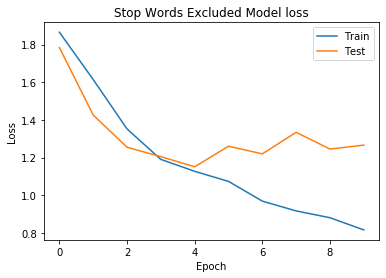

In [7]:
# Plot training & validation loss values
plt.plot(stop_words_excluded_cnn.history.history['loss'])
plt.plot(stop_words_excluded_cnn.history.history['val_loss'])
plt.title('Stop Words Excluded Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Stopwords Included

In [8]:
csv_data = parseCSV('language_dataset_with_stopwords.csv')

csv_data["Word"]= csv_data["Word"].str.lower() 
train_data, test_data = train_test_split(csv_data, test_size=0.2)

print('Number of Words per Language')
csv_data.groupby('Language').size()

Number of Words per Language


Language
English           1000
French            1000
German            1000
Italian           1000
Simlish            111
Spanish           1000
Tolkien Elvish     894
dtype: int64

In [9]:
stop_words_included_cnn = CNN(train_data, test_data)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
C:\Users\takri\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1014)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1014, 93)          8742      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1008, 256)         166912    
_________________________________________________________________
activation_7 (Activation)    (None, 1008, 256)         0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 336, 256)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 330, 256)          459008    
_________________________________________________________________
activation_8 (Activation)    (None, 330, 256)          0   

In [10]:
stop_words_included_test_acc = stop_words_included_cnn.predict(test_data)
stop_words_included_train_acc = stop_words_included_cnn.predict(train_data)

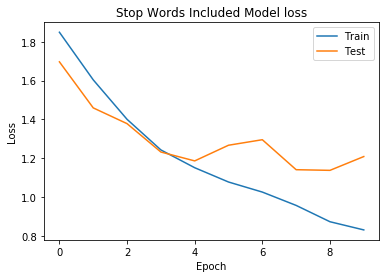

In [11]:
# Plot training & validation loss values
plt.plot(stop_words_included_cnn.history.history['loss'])
plt.plot(stop_words_included_cnn.history.history['val_loss'])
plt.title('Stop Words Included Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Difficult Words Only

In [12]:
csv_data = parseCSV('Difficult_Set.csv')

csv_data["Word"]= csv_data["Word"].str.lower() 
train_data, test_data = train_test_split(csv_data, test_size=0.2)

print('Number of Words per Language')
csv_data.groupby('Language').size()

Number of Words per Language


Language
English           882
French            790
German            862
Italian           811
Simlish           111
Spanish           821
Tolkien Elvish    893
dtype: int64

In [13]:
difficult_words_only_cnn = CNN(train_data, test_data)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
C:\Users\takri\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1014)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1014, 93)          8742      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1008, 256)         166912    
_________________________________________________________________
activation_13 (Activation)   (None, 1008, 256)         0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 336, 256)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 330, 256)          459008    
_________________________________________________________________
activation_14 (Activation)   (None, 330, 256)          0   

In [14]:
difficult_words_only_test_acc = difficult_words_only_cnn.predict(test_data)
difficult_words_only_train_acc = difficult_words_only_cnn.predict(train_data)

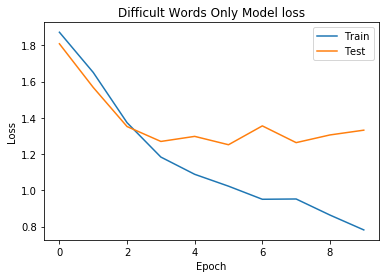

In [15]:
# Plot training & validation loss values
plt.plot(difficult_words_only_cnn.history.history['loss'])
plt.plot(difficult_words_only_cnn.history.history['val_loss'])
plt.title('Difficult Words Only Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Results

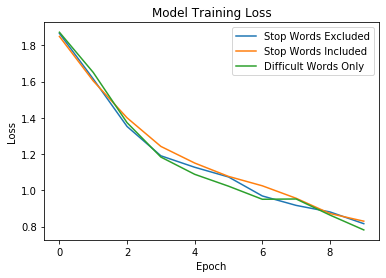

In [16]:
plt.plot(stop_words_excluded_cnn.history.history['loss'])
plt.plot(stop_words_included_cnn.history.history['loss'])
plt.plot(difficult_words_only_cnn.history.history['loss'])

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Stop Words Excluded', 'Stop Words Included', 'Difficult Words Only'], loc='upper right')
plt.show()

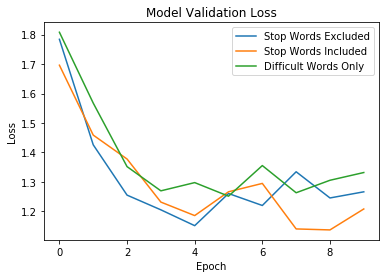

In [17]:
plt.plot(stop_words_excluded_cnn.history.history['val_loss'])
plt.plot(stop_words_included_cnn.history.history['val_loss'])
plt.plot(difficult_words_only_cnn.history.history['val_loss'])

plt.title('Model Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Stop Words Excluded', 'Stop Words Included', 'Difficult Words Only'], loc='upper right')
plt.show()

In [18]:
print('stop words excluded training data accuracy: {:.4f}%'.format(stop_words_excluded_train_acc * 100))
print('stop words excluded testing data accuracy: {:.4f}%'.format(stop_words_excluded_test_acc * 100))
print()
print('stop words included training data accuracy: {:.4f}%'.format(stop_words_included_train_acc * 100))
print('stop words included testing data accuracy: {:.4f}%'.format(stop_words_included_test_acc * 100))
print()
print('difficult words only training data accuracy: {:.4f}%'.format(difficult_words_only_train_acc * 100))
print('difficult words only testing data accuracy: {:.4f}%'.format(difficult_words_only_test_acc * 100))

stop words excluded training data accuracy: 64.2953%
stop words excluded testing data accuracy: 53.7702%

stop words included training data accuracy: 66.5071%
stop words included testing data accuracy: 54.9542%

difficult words only training data accuracy: 70.2128%
difficult words only testing data accuracy: 53.4816%
